In [9]:
#Importing required libraries.

from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook



(60000, 28, 28)


In [ ]:
# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(X_train.shape)

In [10]:
# Preprocessing : This step is crucial for this type of GAN , because here the images fed to discriminator must have a size with channels included.
#Therefore we reshape the b&w images with 1 channel to (28,28,1).

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [17]:
#Using images of 0 only so to make datset smaller and training time faster.

X_train= X_train[Y_train==0]

In [11]:
# Set the dimensions of the noise
z_dim = 100

In [34]:


nch = 200


In [32]:
# Here we define the architecture of GAN which consists of both "generator" and "discriminator". 
#We define architecture of Generator which is fully-convolutional network. It accepts noise as input and generates am image out of it.
#Generator learns when gradients are backpropagated through the network just after discriminator clasifies any image real or fake.
#A special type of convolutional layer is being used here which increases the dimension of input image/array by using transpose convolution notion.
#Because network discriminates between real and generated image , therefore this uses "binary_crossentropy" as loss.
#First encoding is fed to generator which generates an image from it and then subsequently the generated image is fed into discriminator for it to classify
# image as real or fake. 
#Thus in the whole architecture , they both fight against each other. And thus make each other learn more everytime.
adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(7*7*112, input_dim=z_dim))
g.add(Reshape((7, 7, 112)))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(56, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid'))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
g.summary()

d = Sequential()
d.add(Conv2D(56, 5, strides=2, padding='same', input_shape=(28, 28, 1), activation=LeakyReLU(alpha=0.2)))
d.add(Conv2D(112, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Conv2D(224, 5, strides=2, padding='same'))
g.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Flatten())
d.add(Dense(112, activation=LeakyReLU(alpha=0.2)))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
d.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5488)              554288    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 112)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 112)         448       
_________________________________________________________________
activation_9 (Activation)    (None, 7, 7, 112)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 56)        156856    
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 56)        224       
_________________________________________________________________
activation_10 (Activation)   (None, 14, 14, 56)       

In [33]:
#We first make discriminator non-trainable so it just classify images simply and do not learn anything from the data fed to it.
#And we set the complete loss-fnunction and optimizer. Advanced architectures uses various kind of loss so to make it more 
# efficient.

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
gan.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         713221    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1187425   
Total params: 1,900,646
Trainable params: 712,883
Non-trainable params: 1,187,763
_________________________________________________________________


In [13]:
#This is train function which trains the whole architecture in one. 
#First an random noise is generated and is fed to generator "g" which generates some noisy image from it as the generator is not yet trained.
#The generated noisy image is then concatenated with real images and all of them are fed into discriminator. Discriminator is tricked to believe that they
#real images as we give target as "0". It then learns somehting about the real images. 
#Then comes the generator's training. We simply generate some more random noise, set target as "1" so to make the "GAN" believe that they are real images.
#Just then we make discriminator non-trainable and feed this data into whole "GAN" architecture. Thus the generator learns when the loop completes and 
# the gradients flow back assuming that all of the images given were real images.


In [18]:
# Set up a vector (dict) to store the losses
samples = []

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            image_batch = image_batch.reshape(image_batch.shape[0], image_batch.shape[1], image_batch.shape[2], 1)
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            samples.append(generated_images)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)


In [21]:
#Training 50 epochs.
train(epochs=200, plt_frq=20, BATCH_SIZE=128)

Epochs: 200
Batch size: 128
Batches per epoch: 46


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


--------------- Epoch 1 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 40 ---------------
--------------- Epoch 60 ---------------
--------------- Epoch 80 ---------------
--------------- Epoch 100 ---------------
--------------- Epoch 120 ---------------
--------------- Epoch 140 ---------------
--------------- Epoch 160 ---------------
--------------- Epoch 180 ---------------
--------------- Epoch 200 ---------------



In [33]:
#generating random noise and then feeding it to generator which generates some image/array from it .

In [29]:
  n_ex=10
  dim=(1, 10)
  noise = np.random.normal(0, 1, size=(n_ex, z_dim))
  generated_images = g.predict(noise)
  generated_images = generated_images.reshape(generated_images.shape[0], 28, 28)

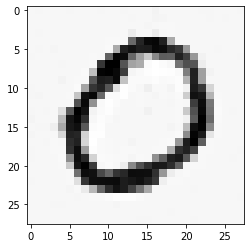

In [30]:
plt.imshow(generated_images[0, :, :], interpolation='nearest', cmap='gray_r')

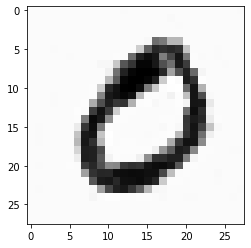

In [31]:
plt.imshow(generated_images[1, :, :], interpolation='nearest', cmap='gray_r')